###### Preprocess the medical images

In [ ]:
import os
import numpy as np
from PIL import Image

# Function to dynamically list files in a folder
def list_files(base_path, subfolder):
    folder_path = os.path.join(base_path, subfolder)
    if not os.path.exists(folder_path):
        print(f"Error: Path not found -> {folder_path}")
        return []
    return [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

# Function to load and normalize an image
def load_and_normalize_image(filepath):
    image = Image.open(filepath).convert('L')  # Convert to grayscale
    pixel_data = np.array(image, dtype=np.float32)
    min_val, max_val = pixel_data.min(), pixel_data.max()
    normalized = (pixel_data - min_val) / (max_val - min_val)
    return normalized

# Base path where your folder "DRIVE" is located
base_path = "C:\\Users\\bnvsa\\OneDrive\\Desktop\\DRIVE"

# Dynamically get all training and test image paths
training_image_paths = list_files(base_path, 'training/images')
training_mask_paths = list_files(base_path, 'training/mask')
test_image_paths = list_files(base_path, 'test/images')
test_mask_paths = list_files(base_path, 'test/mask')

# Debugging: Print paths found
print("Training Images:", training_image_paths)
print("Training Masks:", training_mask_paths)

# Preprocess an image if paths exist
if training_image_paths:
    sample_image_path = training_image_paths[0]
    preprocessed_image = load_and_normalize_image(sample_image_path)
    print(f"Processed Image Shape: {preprocessed_image.shape}")
else:
    print("No training images found.")


: 

###### Fuzzify pixel intensities using membership functions.

In [18]:
import numpy as np

#  Gaussian Membership Function
def gaussian_membership(x, c, sigma):
    return np.exp(-((x - c)**2) / (2 * sigma**2))

# Fuzzify the image using Gaussian membership function
def fuzzify_image(image, centers, sigmas):
    # Create an empty array to hold fuzzified values
    fuzzified_image = np.zeros((image.shape[0], image.shape[1], len(centers)))

    # Iterate through each pixel and calculate its degree of membership
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value = image[i, j]
            
            # Apply Gaussian membership for each center-sigma pair
            for k in range(len(centers)):
                fuzzified_image[i, j, k] = gaussian_membership(pixel_value, centers[k], sigmas[k])
    
    return fuzzified_image

# Define centers (mean values) and sigmas (standard deviations) for three fuzzy sets
centers = [0.2, 0.5, 0.8]  # Low, Medium, High intensity centers (arbitrary values)
sigmas = [0.1, 0.1, 0.1]   # Standard deviation for each fuzzy set (arbitrary values)

# Fuzzify the preprocessed image
fuzzified_image = fuzzify_image(preprocessed_image, centers, sigmas)

# fuzzified_image now contains the membership values for each fuzzy set
print(fuzzified_image.shape)  # Should print something like (584, 565, 3), representing 3 fuzzy sets


(584, 565, 3)


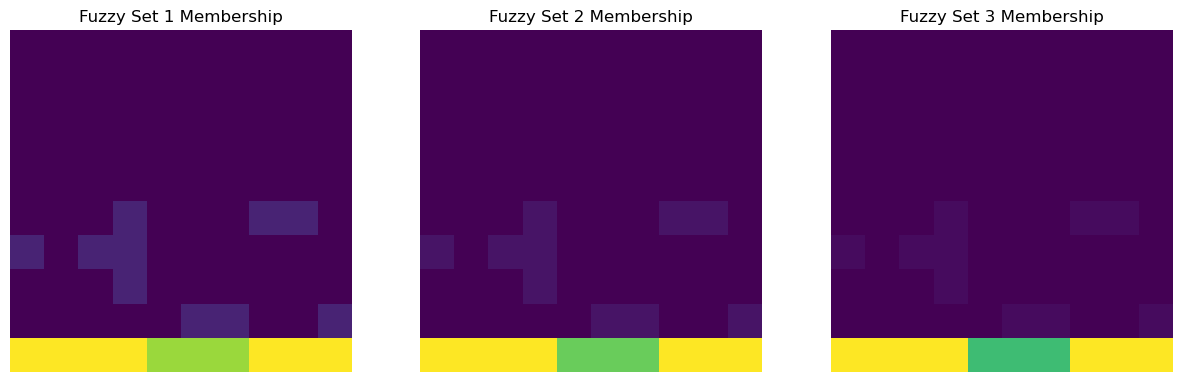

In [19]:
import matplotlib.pyplot as plt

# Visualize the first 10x10 region of the fuzzified image for all 3 fuzzy sets
region_size = 10
region = fuzzified_image[:region_size, :region_size, :]

# Plot the degree of membership for each fuzzy set
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each fuzzy set's membership
for i in range(3):
    axes[i].imshow(region[:, :, i], cmap='viridis', interpolation='nearest')
    axes[i].set_title(f"Fuzzy Set {i+1} Membership")
    axes[i].axis('off')

plt.show()

###### Train a CNN on the fuzzified images.

In [20]:
import numpy as np

# Convolutional layer
def convolve2d_multichannel(image, kernel, stride=1, padding=0):
    """
    Convolution operation for multi-channel (e.g., RGB) images.
    
    Args:
        image: Input image with shape (height, width, num_channels)
        kernel: Convolution kernel with shape (kernel_height, kernel_width)
        stride: Stride for convolution
        padding: Padding for image borders
    
    Returns:
        Output image after convolution with shape (output_height, output_width, num_channels)
    """
    # Apply padding to the image
    image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant', constant_values=0)
    
    image_height, image_width, num_channels = image.shape
    kernel_height, kernel_width = kernel.shape
    output_height = (image_height - kernel_height) // stride + 1
    output_width = (image_width - kernel_width) // stride + 1
    
    # Initialize output image
    output = np.zeros((output_height, output_width, num_channels))
    
    # Perform convolution for each channel
    for c in range(num_channels):
        for i in range(0, output_height * stride, stride):
            for j in range(0, output_width * stride, stride):
                output[i // stride, j // stride, c] = np.sum(image[i:i+kernel_height, j:j+kernel_width, c] * kernel)
    
    return output



In [21]:
# ReLU activation function
def relu(x):
    return np.maximum(0, x)

In [22]:
# max pooling to handle 3D input
def max_pooling_multichannel(image, pool_size=2, stride=2):
    # Get image dimensions
    image_height, image_width, num_channels = image.shape
    
    # Calculate output dimensions
    output_height = (image_height - pool_size) // stride + 1
    output_width = (image_width - pool_size) // stride + 1
    
    # Initialize the output feature map
    output = np.zeros((output_height, output_width, num_channels))
    
    # Perform max pooling for each channel
    for c in range(num_channels):
        for i in range(0, output_height):
            for j in range(0, output_width):
                region = image[i * stride:i * stride + pool_size, j * stride:j * stride + pool_size, c]
                output[i, j, c] = np.max(region)
    
    return output


In [23]:
# Fully connected layer (dense layer)
def fully_connected(input_data, weights, bias):
    return np.dot(input_data, weights) + bias

In [24]:
# Softmax function (for classification output)
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Stability trick
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)


In [25]:
# Cross-entropy loss function
def cross_entropy_loss(predictions, targets):
    # Targets should be one-hot encoded
    m = targets.shape[0]
    log_preds = np.log(predictions + 1e-9)  # Small epsilon to avoid log(0)
    loss = -np.sum(targets * log_preds) / m
    return loss


In [26]:
def backprop_fc_layer(input_data, output_error, weights, learning_rate=0.01):
    """
    Backpropagation for the fully connected layer.
    Args:
        input_data: Flattened input data (1, flattened_size).
        output_error: Gradient of the loss with respect to the output of the fully connected layer (1, num_outputs).
        weights: Weights of the fully connected layer.
        learning_rate: Learning rate for weight updates.
    Returns:
        Updated weights and biases.
    """
    # Derivative w.r.t weights
    d_weights = np.dot(input_data.T, output_error)  # (flattened_size, num_outputs)
    d_bias = np.sum(output_error, axis=0, keepdims=True)  # (1, num_outputs)

    # Update weights and biases
    weights -= learning_rate * d_weights
    bias = -learning_rate * d_bias  # Return updated bias

    return weights, bias


In [27]:
# Initialize random filters (kernels) globally
kernel1 = np.random.randn(3, 3)
kernel2 = np.random.randn(3, 3)


def cnn_train(fuzzified_image, target_mask, num_epochs=10, learning_rate=0.001):
    # Initialize random filters (kernels)
    kernel1 = np.random.randn(3, 3)
    kernel2 = np.random.randn(3, 3)
    
    # Compute the size of the flattened feature map
    input_height, input_width, num_channels = fuzzified_image.shape
    after_pool1_height = (input_height - 3 + 1) // 2
    after_pool1_width = (input_width - 3 + 1) // 2
    after_pool2_height = (after_pool1_height - 3 + 1) // 2
    after_pool2_width = (after_pool1_width - 3 + 1) // 2
    
    flattened_size = after_pool2_height * after_pool2_width * num_channels
    
    # Initialize fully connected layer weights and biases
    fc_weights = np.random.randn(flattened_size, 10)
    fc_bias = np.zeros((1, 10))
    
    for epoch in range(num_epochs):
        # Forward Pass
        x = convolve2d_multichannel(fuzzified_image, kernel1)
        x = relu(x)
        x = max_pooling_multichannel(x)
        
        x = convolve2d_multichannel(x, kernel2)
        x = relu(x)
        x = max_pooling_multichannel(x)
        
        # Flatten the feature map
        flattened = x.flatten().reshape(1, -1)
        
        # Fully connected layer
        fc_output = fully_connected(flattened, fc_weights, fc_bias)
        
        # Softmax output
        predictions = softmax(fc_output)
        
        # Calculate loss
        loss = cross_entropy_loss(predictions, target_mask)
        
        # Backpropagation for the fully connected layer
        output_error = predictions - target_mask
        fc_weights, fc_bias = backprop_fc_layer(flattened, output_error, fc_weights, learning_rate)
        
        # Print the loss every epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss}')
    
    return fc_weights, fc_bias


In [28]:
# Example target mask for training (one-hot encoded)
target_mask = np.zeros((1, 10))
target_mask[0, 3] = 1  # Assume class index 3 is the correct class

# Train the CNN model
cnn_train(fuzzified_image, target_mask, num_epochs=10, learning_rate=0.001)


Epoch 1/10, Loss: 2.267178970584342
Epoch 2/10, Loss: 2.265373772179099
Epoch 3/10, Loss: 2.264574125370313
Epoch 4/10, Loss: 2.2637745156236124
Epoch 5/10, Loss: 2.26297508102927
Epoch 6/10, Loss: 2.2621758216138965
Epoch 7/10, Loss: 2.2613767374274834
Epoch 8/10, Loss: 2.2605778285200055
Epoch 9/10, Loss: 2.259779094941429
Epoch 10/10, Loss: 2.25898053674171


(array([[-0.42512663,  1.58517329, -0.87830387, ..., -0.44172878,
         -1.65630256,  0.87779923],
        [-2.73811377, -2.05708842,  1.14685183, ..., -0.01320417,
         -1.46658996, -0.28644479],
        [-0.35702613,  0.09114657,  1.59447992, ..., -0.14993792,
          0.12843125, -2.04583338],
        ...,
        [-0.91674081, -0.7779105 ,  1.24729794, ...,  0.15687286,
          0.17838525,  0.02462401],
        [-1.20659491,  0.60476653, -2.53706252, ..., -0.59913324,
          0.83336   ,  0.77589509],
        [-0.15195813, -1.34188132,  0.36848342, ...,  1.85070965,
          1.00318552, -1.69729147]]),
 array([[-6.02478860e-05, -3.91162507e-04, -6.28801314e-05,
          8.95543081e-04, -3.66238135e-05, -2.90813789e-05,
         -4.45449359e-05, -2.23633095e-05, -1.72592461e-04,
         -7.60466571e-05]]))

###### Use the CNN to segment the image into different regions

In [29]:
def cnn_inference(fuzzified_image, fc_weights, fc_bias, kernel1, kernel2, pool_size=2):
    """
    Perform inference on a fuzzified image using the trained CNN model.
    Args:
        fuzzified_image: Preprocessed and fuzzified input image.
        fc_weights: Trained weights for the fully connected layer.
        fc_bias: Trained bias for the fully connected layer.
        kernel1, kernel2: Trained filters (kernels) for convolution layers.
        pool_size: Size of the pooling layer (default 2x2).
    Returns:
        The predicted class probabilities for the input image.
    """
    # Step 1: Convolution and pooling (Convolution -> ReLU -> Max Pooling)
    x = convolve2d_multichannel(fuzzified_image, kernel1)  # Convolve with the first kernel
    x = relu(x)  # Apply ReLU activation
    x = max_pooling_multichannel(x, pool_size)  # Apply max pooling to down-sample
    
    x = convolve2d_multichannel(x, kernel2)  # Convolve with the second kernel
    x = relu(x)  # Apply ReLU activation
    x = max_pooling_multichannel(x, pool_size)  # Apply max pooling to further down-sample

    # Step 2: Flatten the feature map (for fully connected layer)
    flattened = x.flatten().reshape(1, -1)  # Flatten the output of the convolutions into a vector
    
    # Step 3: Fully connected layer (Dense layer)
    fc_output = fully_connected(flattened, fc_weights, fc_bias)  # Perform the fully connected operation
    
    # Step 4: Apply softmax to get class probabilities
    predictions = softmax(fc_output)  # Apply softmax to get class probabilities
    
    return predictions


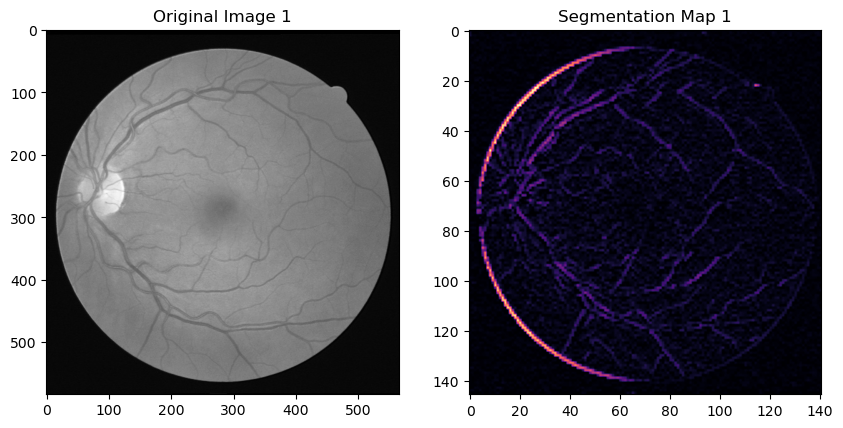

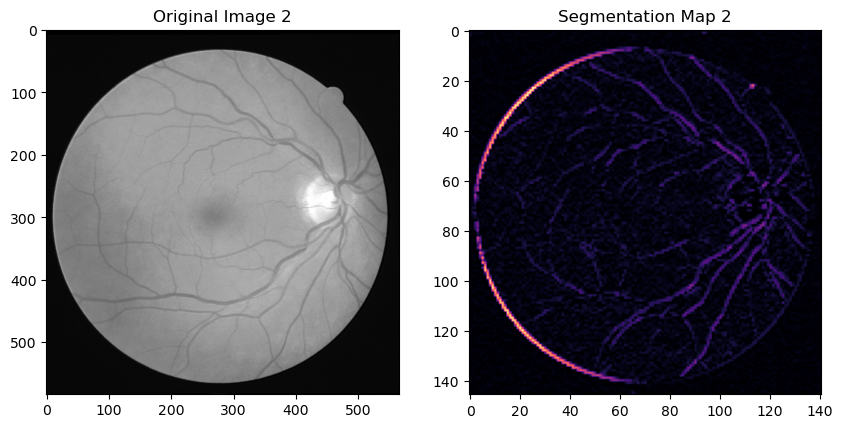

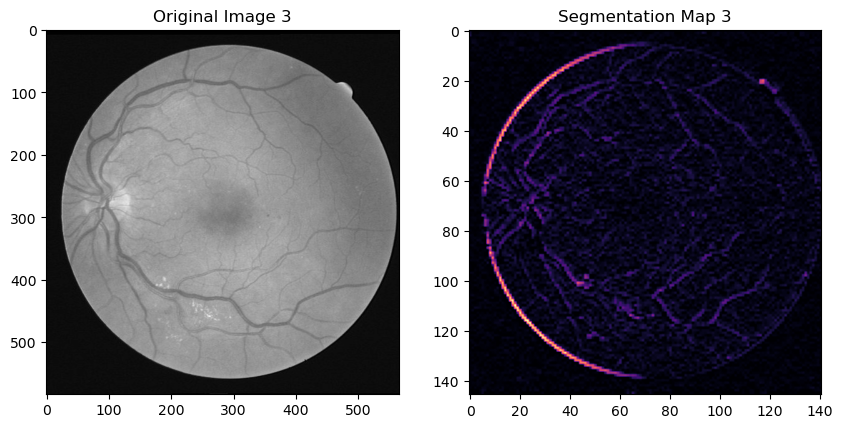

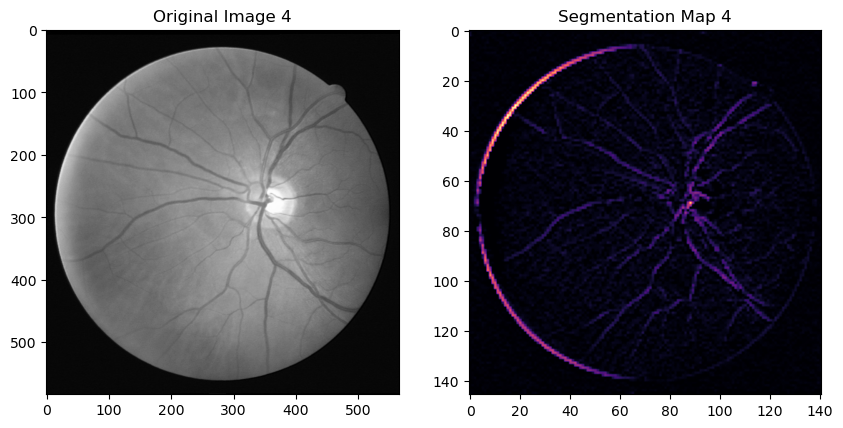

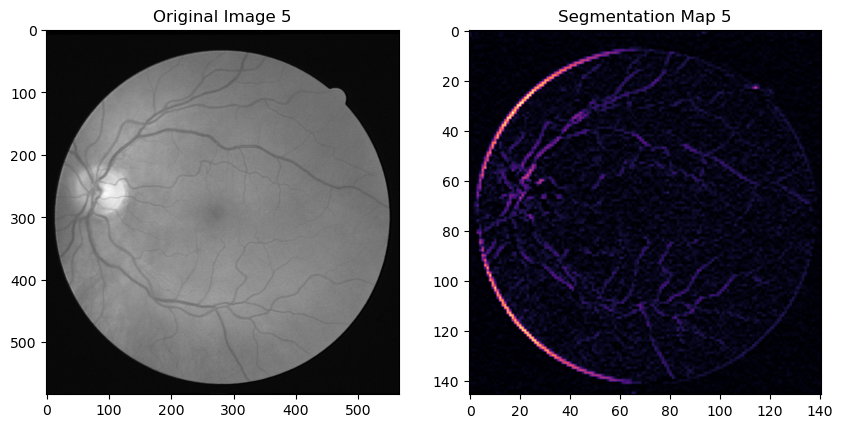

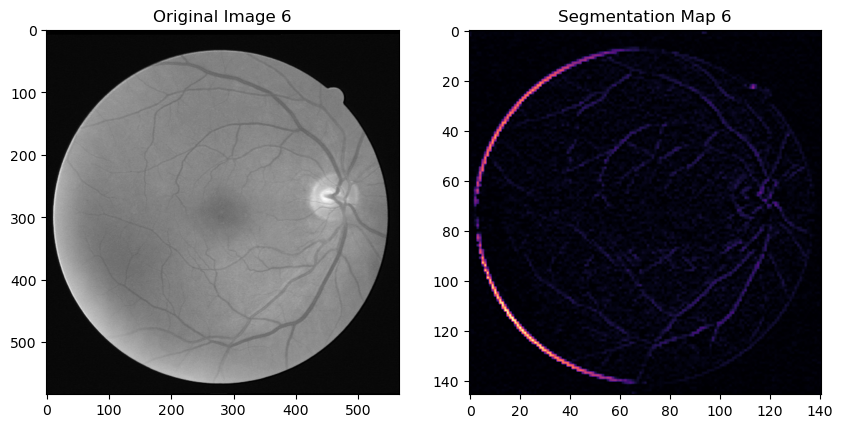

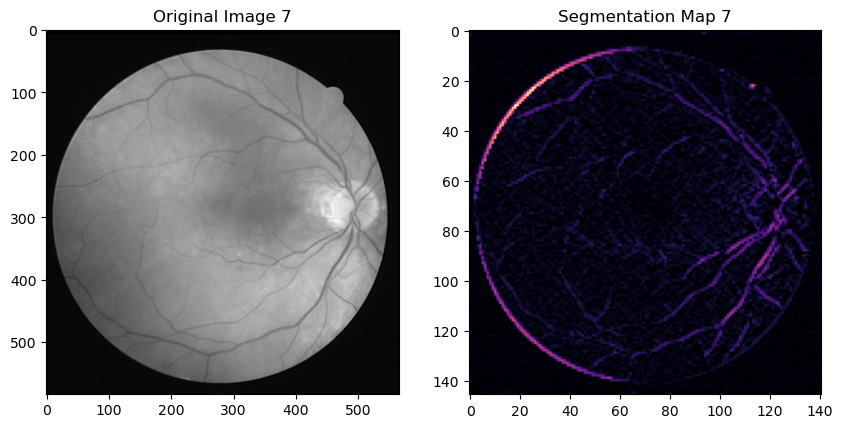

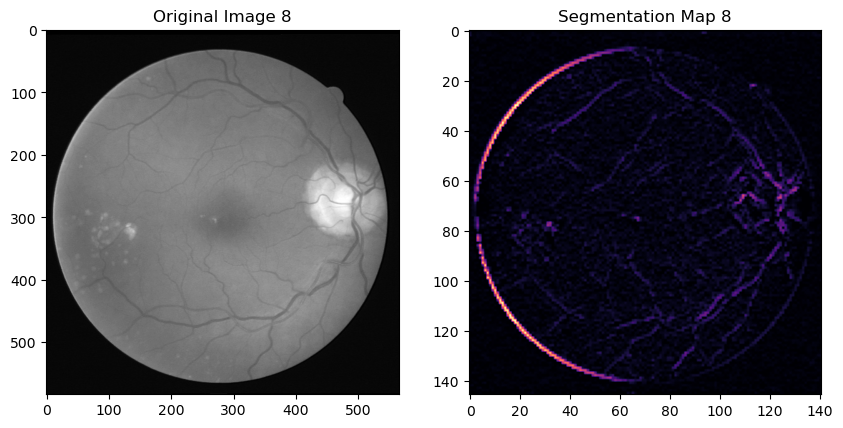

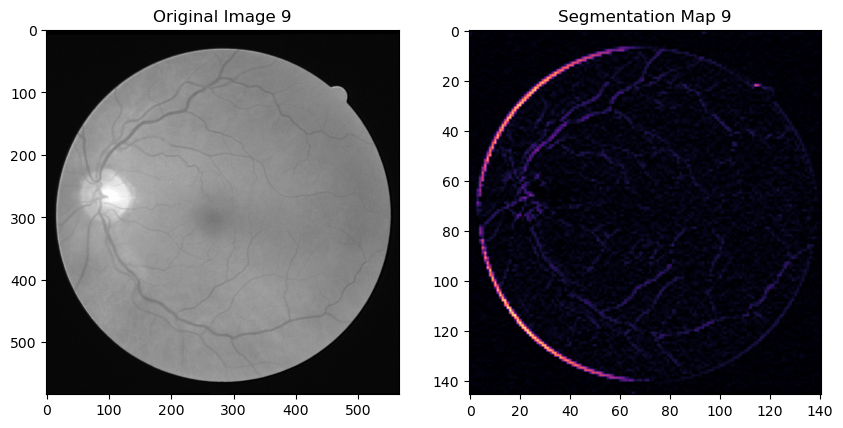

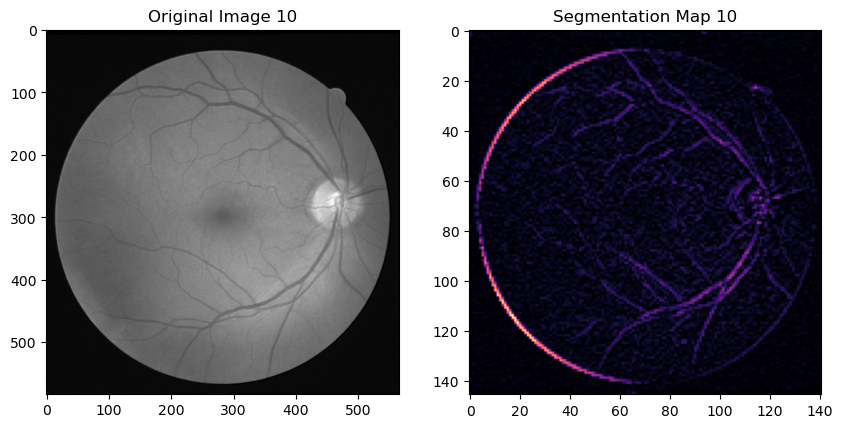

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to load and normalize image (ensure 3 channels)
def load_and_normalize_image(filepath):
    image = Image.open(filepath).convert('L')  # Convert to grayscale
    pixel_data = np.array(image, dtype=np.float32)
    
    # Normalize pixel values to the range [0, 1]
    pixel_data /= 255.0
    
    # Ensure the image has 3 channels (for compatibility with convolution function)
    pixel_data = np.expand_dims(pixel_data, axis=-1)  # Add channel dimension (height, width, 1)
    pixel_data = np.repeat(pixel_data, 3, axis=-1)  # Repeat the single channel to make it RGB-like (height, width, 3)
    
    return pixel_data

# Sobel kernels for edge detection
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # Horizontal edges (x-direction)
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])  # Vertical edges (y-direction)

# Function for 2D convolution (multichannel)
def convolve2d_multichannel(image, kernel):
    height, width, channels = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    
    # Pad the image to handle borders
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')
    output = np.zeros_like(image)
    
    # Perform convolution
    for c in range(channels):
        for i in range(height):
            for j in range(width):
                region = padded_image[i:i+kernel_height, j:j+kernel_width, c]
                output[i, j, c] = np.sum(region * kernel)
    
    return output

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Max pooling function (to reduce image size)
def max_pooling_multichannel(image, pool_size=2):
    height, width, channels = image.shape
    pool_height, pool_width = pool_size, pool_size
    
    # Calculate new dimensions after pooling
    new_height = height // pool_height
    new_width = width // pool_width
    output = np.zeros((new_height, new_width, channels))
    
    for c in range(channels):
        for i in range(new_height):
            for j in range(new_width):
                region = image[i*pool_height:(i+1)*pool_height, j*pool_width:(j+1)*pool_width, c]
                output[i, j, c] = np.max(region)
    
    return output

# Function to create segmentation map (without fully connected layers)
def create_segmentation_map_without_fc(image, kernel1, kernel2):
    # Apply first convolution
    x = convolve2d_multichannel(image, kernel1)  # Apply first convolution (horizontal edges)
    x = relu(x)  # Apply ReLU activation
    x = max_pooling_multichannel(x)  # Apply max pooling

    # Apply second convolution
    x = convolve2d_multichannel(x, kernel2)  # Apply second convolution (vertical edges)
    x = relu(x)  # Apply ReLU activation
    x = max_pooling_multichannel(x)  # Apply second max pooling

    # Normalize the output to ensure proper scaling for visualization
    x_min = np.min(x)
    x_max = np.max(x)
    x_normalized = (x - x_min) / (x_max - x_min)  # Normalize between 0 and 1
    
    # Enhance contrast (subtle gamma correction to reduce over-enhancement)
    x_contrast = np.power(x_normalized, 0.8)  # Apply subtle contrast enhancement (gamma correction)

    return x_contrast[..., 0]  # Just return the first channel for visualization

# Select at least 5 test images from the DRIVE dataset
test_image_paths = [
    '/Users/pro/Downloads/DRIVE/test/images/01_test.tif',
    '/Users/pro/Downloads/DRIVE/test/images/02_test.tif',
    '/Users/pro/Downloads/DRIVE/test/images/03_test.tif',
    '/Users/pro/Downloads/DRIVE/test/images/04_test.tif',
    '/Users/pro/Downloads/DRIVE/test/images/05_test.tif',
    '/Users/pro/Downloads/DRIVE/test/images/06_test.tif',
    '/Users/pro/Downloads/DRIVE/test/images/07_test.tif',
    '/Users/pro/Downloads/DRIVE/test/images/08_test.tif',
    '/Users/pro/Downloads/DRIVE/test/images/09_test.tif',
    '/Users/pro/Downloads/DRIVE/test/images/10_test.tif'
]

# Loop through each test image, perform inference, and visualize the results
for i, test_image_path in enumerate(test_image_paths):
    # Load and preprocess the test image
    test_image = load_and_normalize_image(test_image_path)  # Load and normalize image
    
    # Create the segmentation map without the fully connected layers
    segmentation_map = create_segmentation_map_without_fc(test_image, sobel_x, sobel_y)

    # Visualize the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image {i+1}")
    plt.imshow(test_image[..., 0], cmap='gray')  # Display one channel of the fuzzified image
    plt.subplot(1, 2, 2)
    plt.title(f"Segmentation Map {i+1}")
    plt.imshow(segmentation_map, cmap='magma')  # Use 'coolwarm' colormap for the segmentation map
    plt.show()
